# Imports

In [29]:
# All imports

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import glob
from sklearn.utils import class_weight
import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'1.14.0'

# Data Loading

In [3]:
# importing files
import zipfile
with zipfile.ZipFile('./Trafficdataset_Signtypes.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [30]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('./Trafficdataset_Signtypes/*/*.png', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
    image_list.append((filepath, label))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

# Inspecting Data

In [31]:
data.shape

(3699, 2)

In [32]:
data.label.unique()

array(['parking', 'stop', 'rightofway', 'warning', 'limitedtraffic',
       'noparking', 'speed', 'bicycle', 'giveway', 'traveldirection',
       'continue', 'crossing', 'trafficdirective', 'noentry', 'laneend',
       'roundabout'], dtype=object)

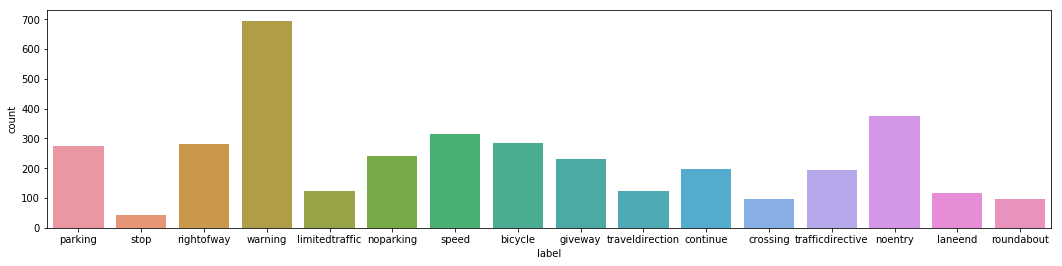

In [33]:
import seaborn as sns
plt.figure(figsize=(18,4))
sns.countplot(x='label', data=data)

# Dsiplay sample image

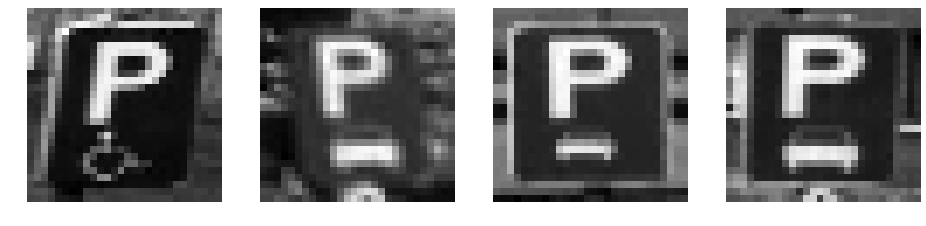

In [34]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

# Label Mapping

In [35]:
d = {'parking':0, 'stop':1, 'rightofway':2, 'warning':3, 'limitedtraffic':4, 'noparking':5,
     'speed':6, 'bicycle':7, 'giveway':8, 'traveldirection':9, 'continue':10, 'crossing':11, 'trafficdirective':12,
     'noentry':13, 'laneend':14, 'roundabout':15}
data['labels_num'] = data['label'].map(d, na_action='ignore')

# Test Train split

In [36]:
temptrainData, testData = train_test_split(data ,test_size=0.20, random_state=42)
trainData, validateData = train_test_split(temptrainData ,test_size=0.25, random_state=42)

In [37]:
print(trainData.shape)
print(testData.shape)
print(validateData.shape)

(2219, 3)
(740, 3)
(740, 3)


In [38]:
N_train_images = trainData.shape[0]
N_val_images = validateData.shape[0]
N_test_images = testData.shape[0]

# Data Generator

Data Generator is used load images in a batch and augment the image 

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1
batch_size = 16

# for training dataset
train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

# for validation data set
validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validateData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

# for testing(internal) data set
test_generator = test_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
shuffle = False)

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


# Utility functions

Results

In [40]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res.history['loss'])
    plt.plot(res.history['val_loss'])
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(res.history['categorical_accuracy'])
    plt.plot(res.history['val_categorical_accuracy'])
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')

# CNN Model 

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
#model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(16))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
activation_10 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_12 (Activation)   (None, 9, 9, 64)         

In [47]:
# Setting weights according to the class representation
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

In [48]:
model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=validation_generator, class_weight=class_weights, epochs=50)

Epoch 1/50
139/139 [==============================] - 3s 25ms/step - loss: 2.6618 - categorical_accuracy: 0.1708 - val_loss: 2.4933 - val_categorical_accuracy: 0.1986
Epoch 2/50
139/139 [==============================] - 3s 21ms/step - loss: 2.5131 - categorical_accuracy: 0.2127 - val_loss: 2.0088 - val_categorical_accuracy: 0.3851
Epoch 3/50
139/139 [==============================] - 3s 21ms/step - loss: 2.1816 - categorical_accuracy: 0.3411 - val_loss: 1.5416 - val_categorical_accuracy: 0.6216
Epoch 4/50
139/139 [==============================] - 3s 21ms/step - loss: 1.8528 - categorical_accuracy: 0.4353 - val_loss: 1.2313 - val_categorical_accuracy: 0.6338
Epoch 5/50
139/139 [==============================] - 3s 22ms/step - loss: 1.5911 - categorical_accuracy: 0.5304 - val_loss: 0.7852 - val_categorical_accuracy: 0.7500
Epoch 6/50
139/139 [==============================] - 3s 21ms/step - loss: 1.3895 - categorical_accuracy: 0.5831 - val_loss: 0.6201 - val_categorical_accuracy: 0.856

In [43]:
plot_results(res)

NameError: name 'res' is not defined

# Predicting

First we will predit it on our own test data which was initially seperated from the training set

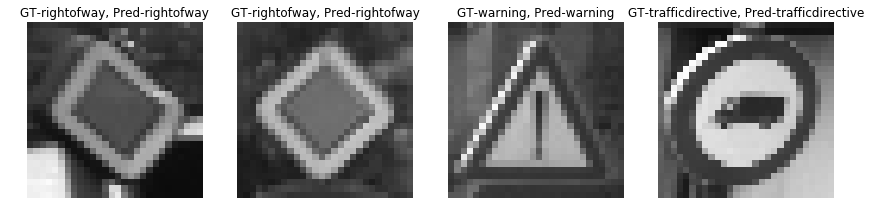

In [49]:
labels = (test_generator.class_indices)

d_inv = {v: k for k, v in labels.items()}
plt.figure(figsize=(22,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cnn.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,6,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [50]:
model_cnn.evaluate(test_generator)

740/740 [==============================] - 1s 2ms/step - loss: 0.2851 - categorical_accuracy: 0.9405


[0.28514774664229636, 0.94054055]

# Independent Evaluation